In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import date, timedelta

import timeit
import functools

import mechafil_jax.power as jax_power
import mechafil.power as np_power
import mechafil.data as data

import numpy as np
import jax.numpy as jnp
import jax

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [3]:
data.setup_spacescope('/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json')

forecast_length = 10*365  # make this large so we can then sweep over different times
start_date = date(2021, 3, 16)
current_date = date.today() - timedelta(days=2)
end_date = current_date + timedelta(days=forecast_length)

In [4]:
# Get sector scheduled expirations
res = data.get_sector_expiration_stats(start_date, current_date, end_date)
rb_known_scheduled_expire_vec = res[0]
qa_known_scheduled_expire_vec = res[1]

fil_stats_df = data.get_historical_network_stats(start_date, current_date, end_date)
current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]
# Forecast power stats
rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

In [5]:
rbp = 6
rr = 0.6
fpr = 0.6

duration = 360

In [6]:
mechafil_rb_df, mechafil_qa_df = np_power.forecast_power_stats(
    rb_power_zero, qa_power_zero, rbp, rb_known_scheduled_expire_vec, qa_known_scheduled_expire_vec,
    rr, fpr, duration, forecast_length, qap_method='basic'
)

In [7]:
rbp_vec = jnp.ones(forecast_length)*rbp
rr_vec = jnp.ones(forecast_length)*rr
fpr_vec = jnp.ones(forecast_length)*fpr

In [8]:
jax_rb_dict, jax_qa_dict = jax_power.forecast_power_stats(
    rb_power_zero, qa_power_zero, 
    rbp_vec, rb_known_scheduled_expire_vec, qa_known_scheduled_expire_vec,
    rr_vec, fpr_vec, duration, forecast_length,
)

<IPython.core.display.Javascript object>


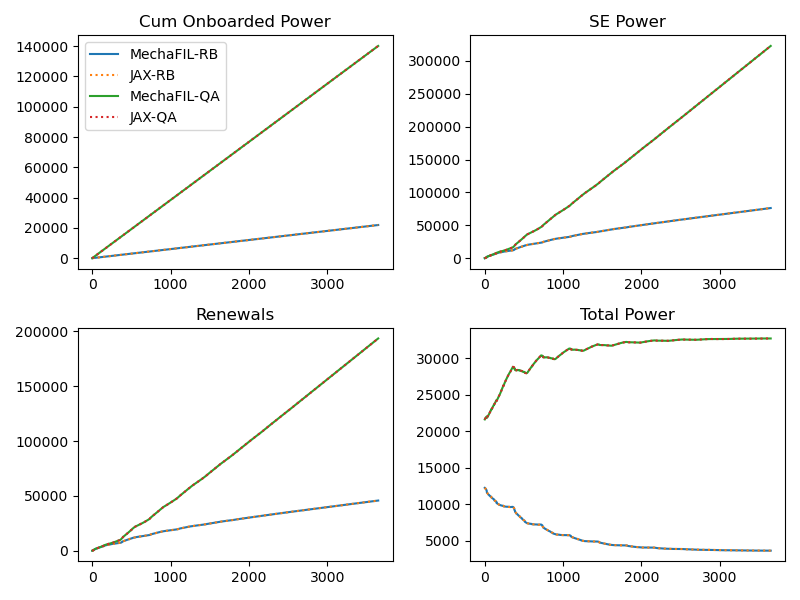

In [9]:
plt.figure(figsize=(8,6))

plt.subplot(2,2,1)
plt.plot(mechafil_rb_df['cum_onboarded_power'], label='MechaFIL-RB')
plt.plot(jax_rb_dict['cum_onboarded_power'], label='JAX-RB', linestyle=':')
plt.plot(mechafil_qa_df['cum_onboarded_power'], label='MechaFIL-QA')
plt.plot(jax_qa_dict['cum_onboarded_power'], label='JAX-QA', linestyle=':')
plt.title('Cum Onboarded Power')
plt.legend()

plt.subplot(2,2,2)
plt.plot(mechafil_rb_df['cum_expire_scheduled_power'], label='MechaFIL-RB')
plt.plot(jax_rb_dict['cum_expire_scheduled_power'], label='JAX-RB', linestyle=':')
plt.plot(mechafil_qa_df['cum_expire_scheduled_power'], label='MechaFIL-QA')
plt.plot(jax_qa_dict['cum_expire_scheduled_power'], label='JAX-QA', linestyle=':')
plt.title('SE Power')

plt.subplot(2,2,3)
plt.plot(mechafil_rb_df['cum_renewed_power'], label='MechaFIL-RB')
plt.plot(jax_rb_dict['cum_renewed_power'], label='JAX-RB', linestyle=':')
plt.plot(mechafil_qa_df['cum_renewed_power'], label='MechaFIL-QA')
plt.plot(jax_qa_dict['cum_renewed_power'], label='JAX-QA', linestyle=':')
plt.title('Renewals')

plt.subplot(2,2,4)
plt.plot(mechafil_rb_df['total_power'], label='MechaFIL-RB')
plt.plot(jax_rb_dict['total_power'], label='JAX-RB', linestyle=':')
plt.plot(mechafil_qa_df['total_power'], label='MechaFIL-QA')
plt.plot(jax_qa_dict['total_power'], label='JAX-QA', linestyle=':')
plt.title('Total Power')

plt.tight_layout()

In [10]:
%%timeit

jax.block_until_ready(jax_power.forecast_power_stats(
    rb_power_zero, qa_power_zero, 
    rbp_vec, rb_known_scheduled_expire_vec, qa_known_scheduled_expire_vec,
    rr_vec, fpr_vec, duration, forecast_length,
))

153 µs ± 322 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [11]:
%%timeit

mechafil_rb_df, mechafil_qa_df = np_power.forecast_power_stats(
    rb_power_zero, qa_power_zero, rbp, rb_known_scheduled_expire_vec, qa_known_scheduled_expire_vec,
    rr, fpr, duration, forecast_length, qap_method='basic'
)

6.42 ms ± 90.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
num_mc = 100

In [19]:
forecast_len_yrs_vec = np.arange(1,10)

mechafil_speeds = []
jax_speeds = []

for forecast_length_yrs in tqdm(forecast_len_yrs_vec):
    forecast_length_days = forecast_length_yrs*365
    
    t = timeit.Timer(
        functools.partial(np_power.forecast_power_stats,
            rb_power_zero, qa_power_zero, rbp, rb_known_scheduled_expire_vec, qa_known_scheduled_expire_vec,
            rr, fpr, duration, forecast_length_days, qap_method='basic'
        )
    )
    mechafil_speed = t.timeit(num_mc)/num_mc
    mechafil_speeds.append(mechafil_speed)

# now time jax
for forecast_length_yrs in tqdm(forecast_len_yrs_vec):
    forecast_length_days = int(forecast_length_yrs*365)
    
    rbp_vec = jnp.ones(forecast_length_days)*rbp
    rr_vec = jnp.ones(forecast_length_days)*rr
    fpr_vec = jnp.ones(forecast_length_days)*fpr
    
    # force a compile
    jax_power.forecast_power_stats(
        rb_power_zero, qa_power_zero, 
        rbp_vec, rb_known_scheduled_expire_vec, qa_known_scheduled_expire_vec,
        rr_vec, fpr_vec, duration, forecast_length_days,
    )
    
    t = timeit.Timer(
        functools.partial(jax.block_until_ready(jax_power.forecast_power_stats),
            rb_power_zero, qa_power_zero, 
            rbp_vec, rb_known_scheduled_expire_vec, qa_known_scheduled_expire_vec,
            rr_vec, fpr_vec, duration, forecast_length_days,
        )
    )
    jax_speed = t.timeit(num_mc)/num_mc
    jax_speeds.append(jax_speed)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


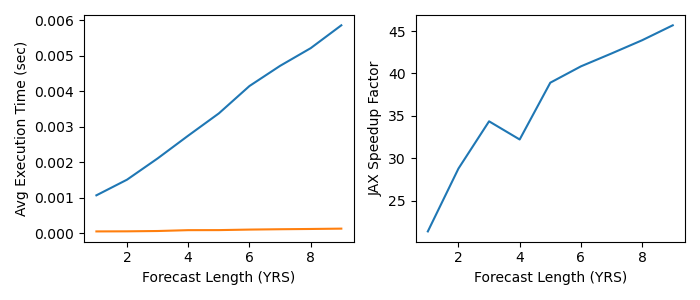

In [20]:
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.plot(forecast_len_yrs_vec, mechafil_speeds, label='MechaFIL')
plt.plot(forecast_len_yrs_vec, jax_speeds, label='JAX')
plt.xlabel('Forecast Length (YRS)')
plt.ylabel('Avg Execution Time (sec)')

plt.subplot(1,2,2)
plt.plot(forecast_len_yrs_vec, np.asarray(mechafil_speeds)/np.asarray(jax_speeds))
plt.xlabel('Forecast Length (YRS)')
plt.ylabel('JAX Speedup Factor')
plt.tight_layout()